# Data & Library import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [2]:
data = pd.read_csv("dataset.csv",delimiter=';')
data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


# Data Pre-Processing

Choosing best feature

In [3]:
# fix label name
data = data.rename({'Nactionality':'Nationality'})

In [4]:
# run only once
le = preprocessing.LabelEncoder()
data["Target"] = le.fit_transform(data["Target"])
# 0 : Drop out 
# 1 : Enrolled
# 2 : Graduate

In [28]:
feature = data.drop(columns=["Target"])
target = data.Target

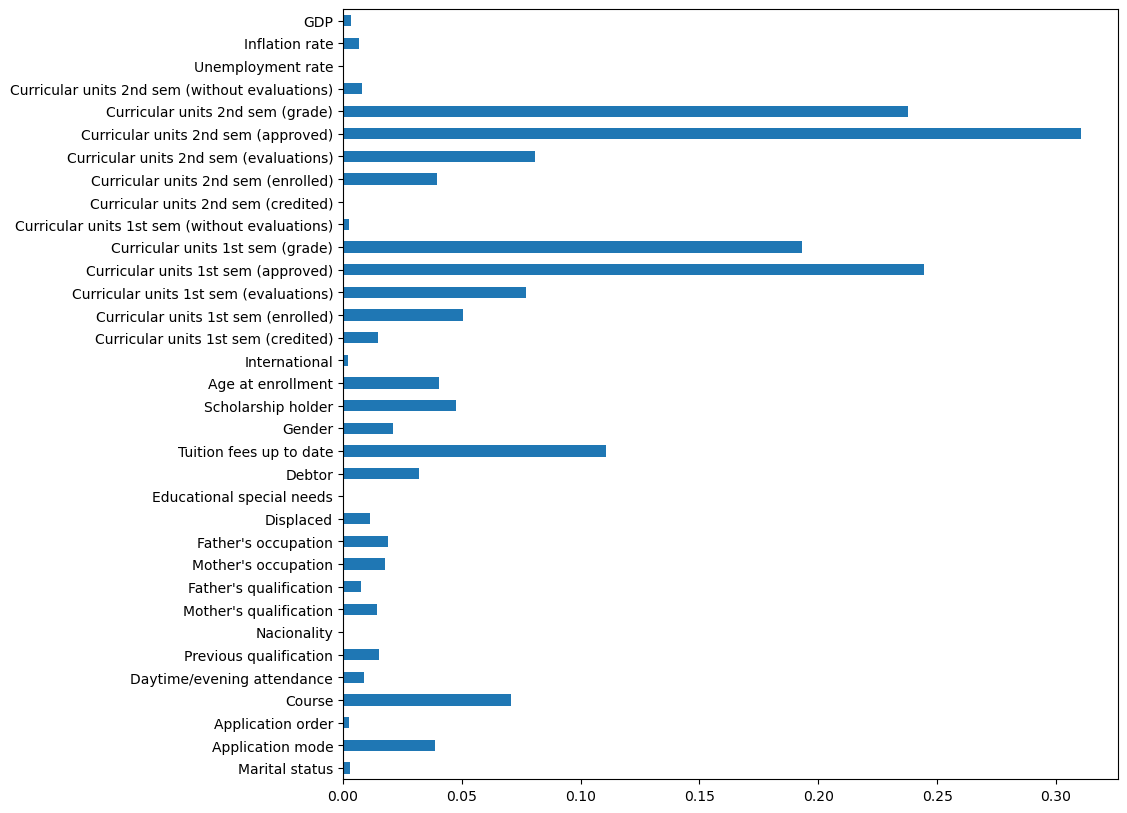

In [29]:
importance = mutual_info_classif(feature,target)
ft_imp = pd.Series(importance, data.columns[0:len(data.columns)-1])
ft_imp.plot(kind="barh",figsize=(10,10))
plt.show()

In [177]:
num_features = 14
largest = ft_imp.nlargest(num_features).index
feature_select = feature[largest]
print(largest)

Index(['Curricular units 2nd sem (approved)',
       'Curricular units 1st sem (approved)',
       'Curricular units 2nd sem (grade)', 'Curricular units 1st sem (grade)',
       'Tuition fees up to date', 'Curricular units 2nd sem (evaluations)',
       'Curricular units 1st sem (evaluations)', 'Course',
       'Curricular units 1st sem (enrolled)', 'Scholarship holder',
       'Age at enrollment', 'Curricular units 2nd sem (enrolled)',
       'Application mode', 'Debtor'],
      dtype='object')


In [186]:
categorical_labels = ['Tuition fees up to date','Scholarship holder','Application mode','Debtor']
categorical_input = feature_select[categorical_labels]
continuous_input = feature_select.drop(columns=categorical_labels)

4


### (LEGACY DO NOT USE) Filtering out 0's. But since they're tied with categorical, we can use this as another way of managing NNs.

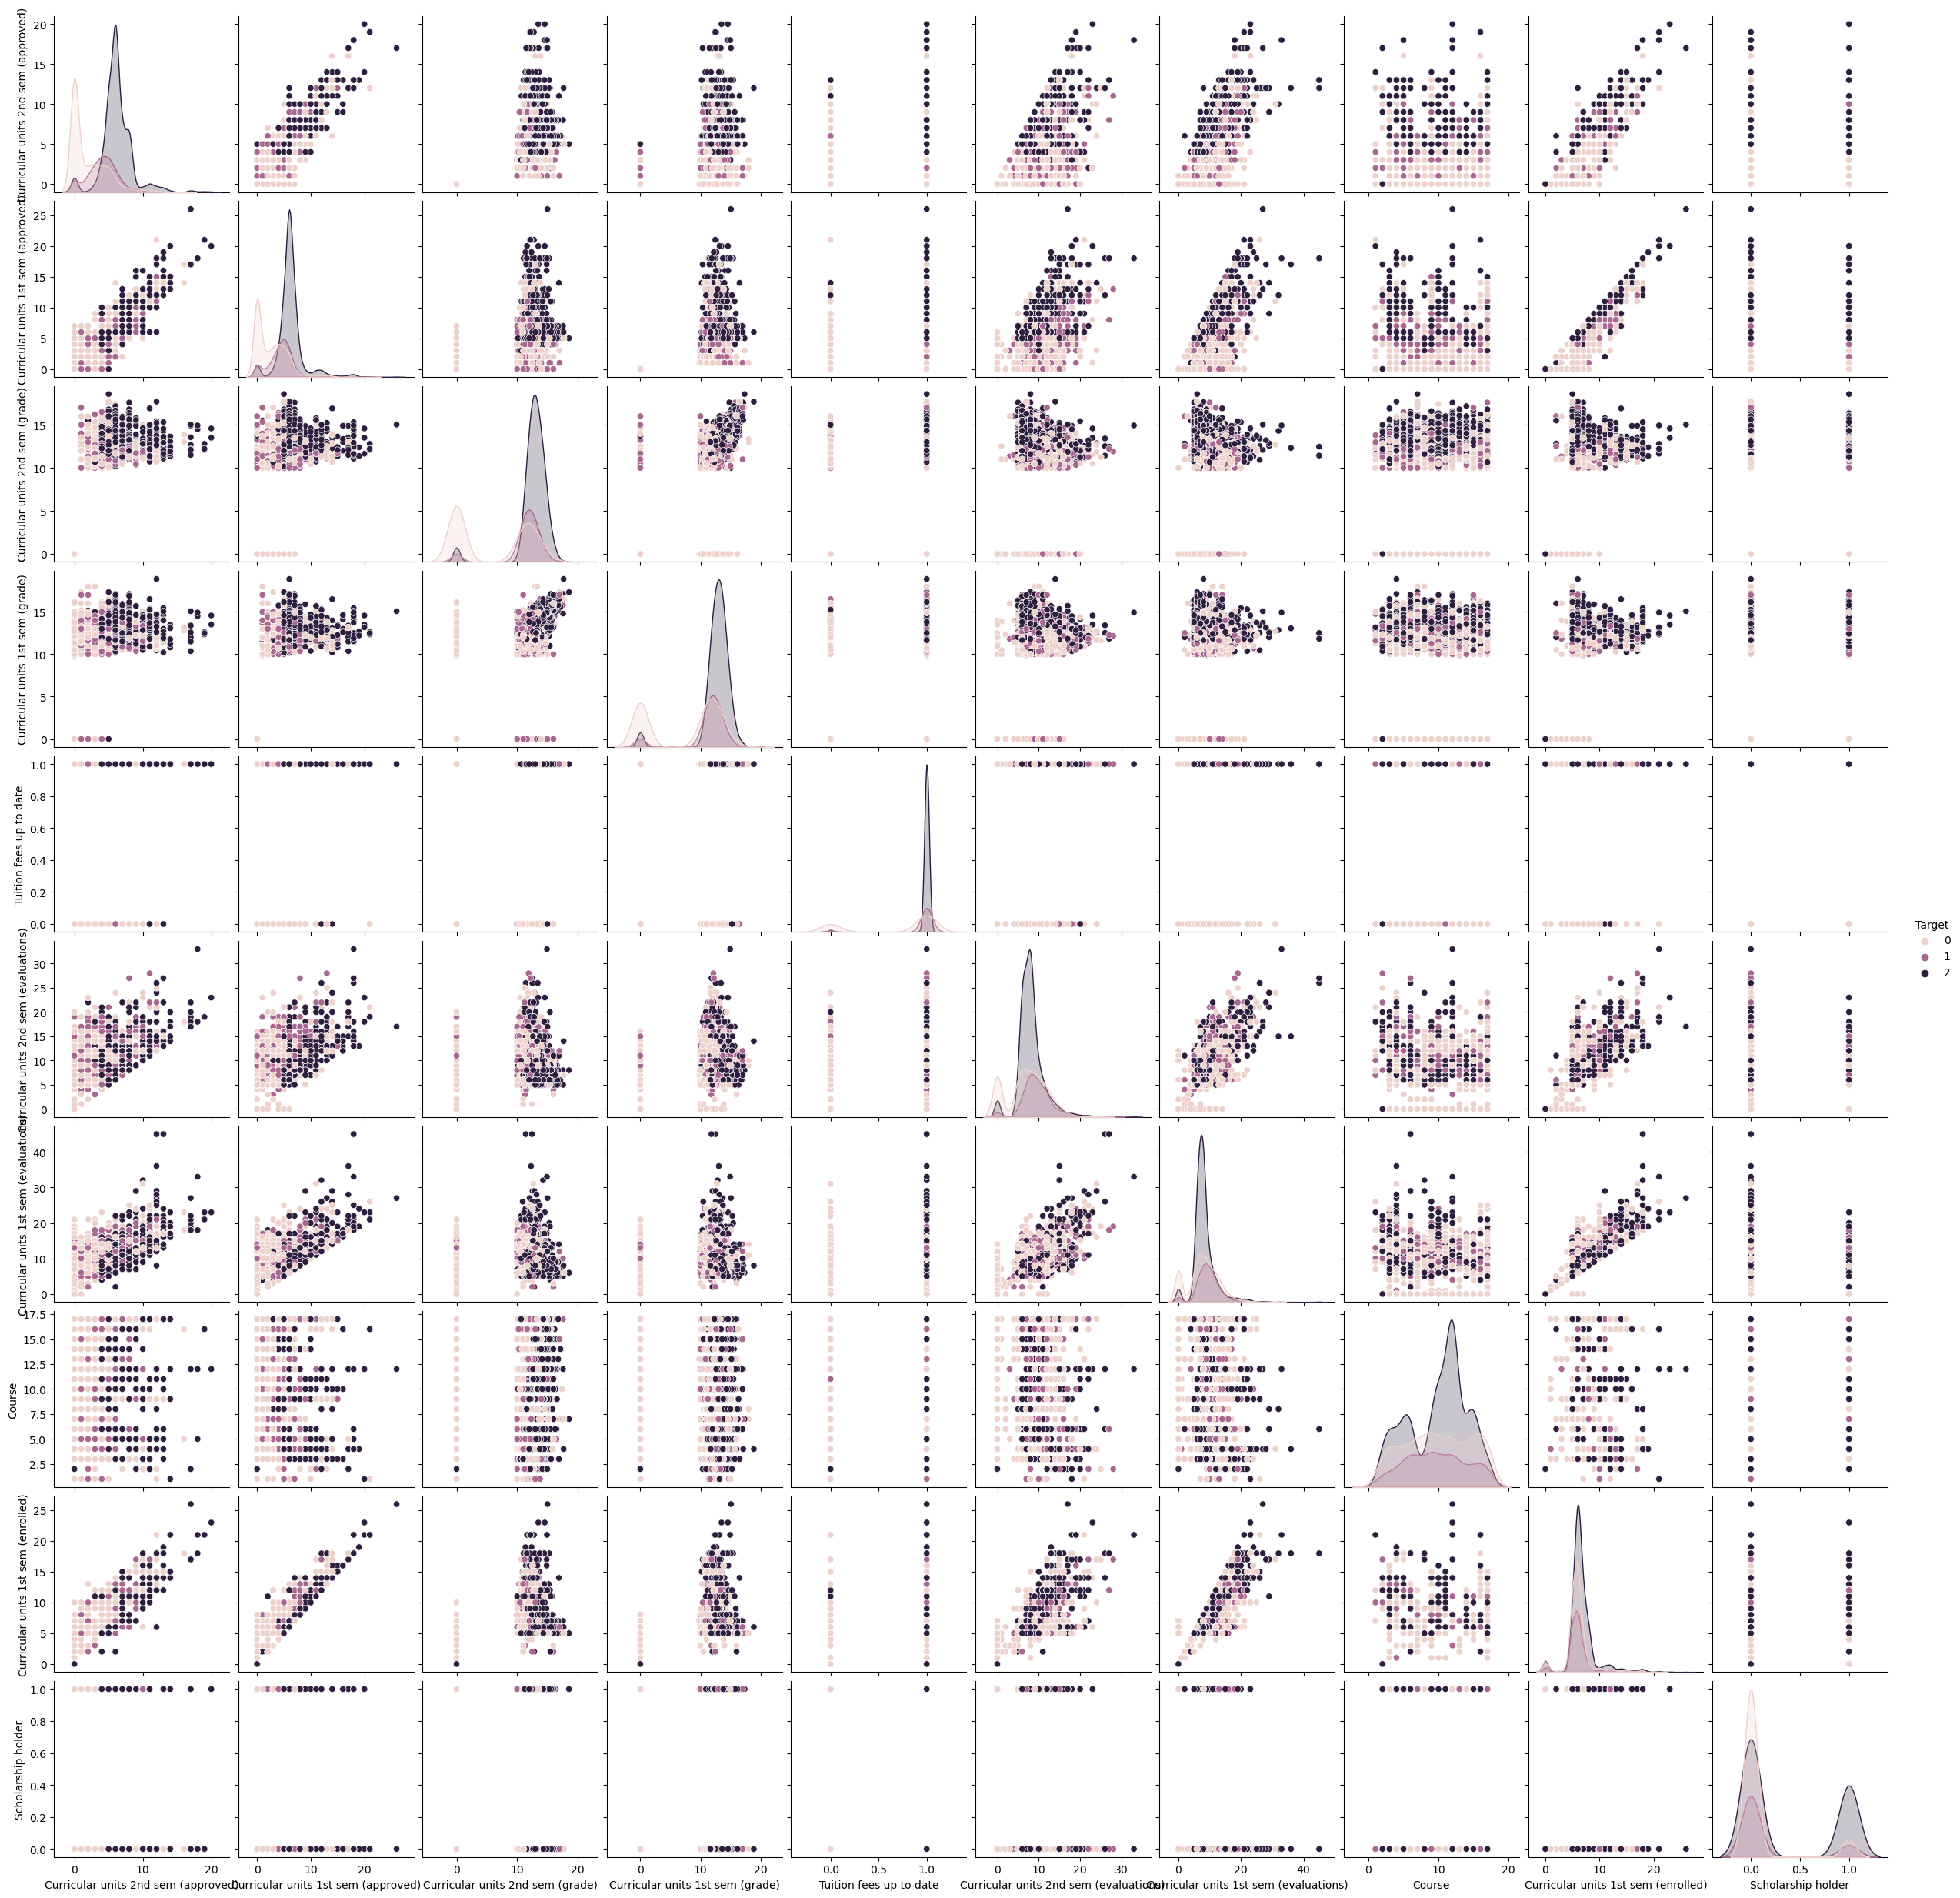

In [176]:
sns.pairplot(feature_select.assign(Target=target),hue='Target')
plt.show()

In [145]:
locs = ~(feature_select==0).any(axis=1)
feature_select_filtered = feature_select.loc[locs]
target_filtered = target.loc[locs]


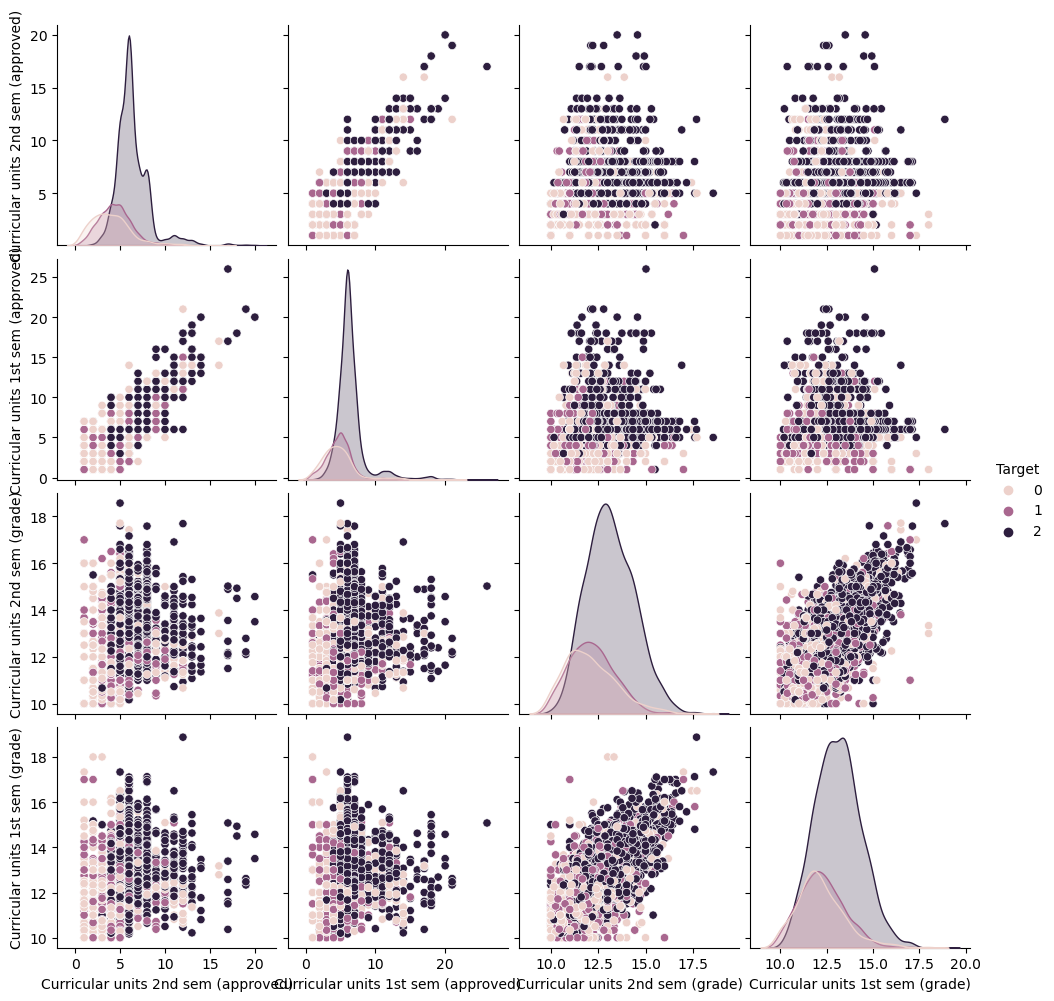

In [146]:
sns.pairplot(feature_select_filtered.assign(Target=target_filtered.values),hue='Target')
plt.show()

Turning data into tensor

In [184]:
test_size = 0.33
random_state = 42 # same split

X_cont_train, X_cont_test, Y_train, Y_test = train_test_split(
  feature_select_filtered, target_filtered, test_size=test_size, random_state=random_state)

X_cat_train, X_cat_test, _, _ = train_test_split(
  feature_select_filtered, target_filtered, test_size=test_size, random_state=random_state)

In [148]:
X_cont_train_np = X_cont_train.values
X_cont_test_np = X_cont_test.values
X_cat_train_np = X_cat_train.values
X_cat_test_np = X_cat_test.values
Y_train_np = Y_train.values
Y_test_np = Y_test.values

In [149]:
class Data(Dataset):
  def __init__(self, X_train_cont, X_train_cat, y_train):

    self.X_cont = torch.from_numpy(X_train_cont.astype(np.float32))
    self.X_cat = torch.from_numpy(X_train_cat.astype(np.float32))
    self.y = torch.from_numpy(y_train).type(torch.LongTensor)
    self.len = self.X_cont.shape[0]
  
  def __getitem__(self, index):
    return self.X_cont[index], self.X_cat[index], self.y[index]
  def __len__(self):
    return self.len

In [150]:
traindata = Data(X_cont_train_np,X_cat_train_np,Y_train_np)

In [151]:
batch_size = 50
trainloader = DataLoader(traindata, batch_size=batch_size, 
                         shuffle=True, num_workers=0)

In [207]:
unique_values = [X_cat_train[col].nunique() for col in X_cat_train.columns]
num_cont = num_features - len(categorical_labels)
num_cat = len(categorical_labels)

embedding_dim = []
for i in unique_values:
    embedding_dim.append(int(max(2, min(50, round(1.6 * pow(len(X_cat_train), 0.56) / pow(i, 0.25)))) // 2 * 2))

input_dim = num_features + sum(embedding_dim)
output_dim = 3
hidden = (input_dim + output_dim) // 2
print(embedding_dim)

[50, 50, 24, 24]


In [195]:
class Network(nn.Module):
    def __init__(self, num_cont, embedding_dim):
        super().__init__()

        # Define the input layers
        self.input_layers = []
        self.input_layers.append(nn.Linear(num_cont, hidden)) # continuous variable
        for dim in embedding_dim:
            self.input_layers.append(nn.Embedding(dim, hidden))

        # Define the hidden layers
        self.hidden_layer_1 = nn.Linear(hidden,hidden)

        # Define the output layer
        self.output_layer = nn.Linear(hidden, output_dim)

    def forward(self, x_continuous, x_categoricals):
        # Concatenate the input layers
        x = torch.cat([layer(x_cat) for layer, x_cat in zip(self.input_layers, [x_continuous] + x_categoricals)], dim=1)

        # Forward pass through the network
        x = torch.relu(self.hidden_layer_1(x))
        x = torch.sigmoid(self.output_layer(x))

        return x

In [193]:
clf = Network(num_cont, num_cat, embedding_dim)
print(clf.parameters)

NameError: name 'num_cont' is not defined

In [155]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(clf.parameters(), lr=0.001)

# Training

In [163]:
epochs = 300
loss_arr = [i for i in range(epochs)]
for epoch in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    # set optimizer to zero grad to remove previous epoch gradients
    optimizer.zero_grad()
    # forward propagation
    outputs = clf(inputs)
    loss = criterion(outputs, labels)
    # backward propagation
    loss.backward()
    # optimize
    optimizer.step()
    running_loss += loss.item()
  # display statistics
  if epoch % 100 == 0:
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.5f}')
  loss_arr[epoch] = running_loss/2000

[1,    24] loss: 0.00923
[101,    24] loss: 0.00914
[201,    24] loss: 0.00904


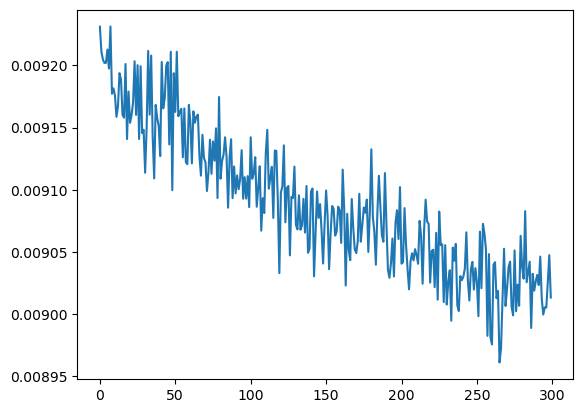

In [164]:
plt.plot(loss_arr)

# Testing

In [165]:
testdata = Data(X_test_np, Y_test_np)
testloader = DataLoader(testdata,batch_size=testdata.len,
                        shuffle=True, num_workers=0)

In [166]:
dataiter = iter(testloader)
inputs, labels = next(dataiter)

In [167]:
outputs = clf(inputs)
__, predicted = torch.max(outputs, 1)

In [168]:
correct, total = 0, 0
# no need to calculate gradients during inference
with torch.no_grad():
  for dat in testloader:
    inputs, labels = dat
    # calculate output by running through the network
    outputs = clf(inputs)
    # get the predictions
    __, predicted = torch.max(outputs.data, 1)
    # update results
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the {len(testdata)} test data: {100 * correct / total} %')

Accuracy of the network on the 1159 test data: 69.28386540120793 %


In [132]:
rand_predictions = np.random.randint(0,3,size=testdata.len)

correct, total = 0, 0
for dat in rand_predictions:
    total += labels.size(0)
    correct += (dat == labels).sum().item()
print(f"{100*correct//total}%")

32%


___
# WONJOONCHOI

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.neural_network import MLPClassifier

# Data Preprocessing

In [2]:
data = pd.read_csv('dataset.csv', delimiter=';')
number_of_pairs = data.index.stop

In [3]:
le = preprocessing.LabelEncoder()
data["Target"] = le.fit_transform(data["Target"])
# 0 : Drop out 
# 1 : Enrolled
# 2 : Graduate

In [4]:
feature = data.drop(columns=["Target"])
target = data.Target

In [5]:
input_patterns = []
for i in range(number_of_pairs):
    input_patterns.append(feature.iloc[i].to_list())

In [6]:
X_train, X_test, y_train, y_test = train_test_split(input_patterns,target)

# Define Helper Functions 

In [7]:
def plot_confusion_matrix(matrix,title=""): 
    #put the heatmap into the figure 
    sns.heatmap(data=matrix, annot=True, cmap="crest")
    status=["Drop-out","Enrolled","Graduate"]
    axis_ticks=np.arange(len(status))+0.4
    
    #sets x axis ticks to species names
    plt.xticks(axis_ticks,status) 
    
    #sets y axis ticks to species names 
    plt.yticks(axis_ticks,status) 
    plt.title(title)
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")

In [8]:
def find_best_depth(model): 
    # Max Depth iteration
    N = 30
    # set initial list length of N
    scores = np.zeros(N)
    best_score = -np.inf
    for d in range(1,N+1):
                # set model with random state
        ref = model(max_depth=d,random_state=1111)
        # calculate score
        scores[d-1] = cross_val_score(ref,X_train,y_train,cv=5).mean() 
        if scores[d-1] >best_score:
                # update best_score and best_depth
                best_score=scores[d-1]
                best_depth = d
        # plot scatter plot
    fig, ax = plt.subplots(1) 
    ax.scatter(np.arange(1,N+1),scores)
    ax.set(title="Best Depth: " + str(best_depth)) 
    return best_depth

# CNN 

In [11]:
nn = MLPClassifier(hidden_layer_sizes = (100),
                   activation = "relu", # Activation function for the hidden layer.
                   solver = "adam", # The solver for weight optimization.
                   alpha = 0.0001, # Strength of the L2 regularization term.
                   batch_size = 'auto',# Size of minibatches for stochastic optimizers.
                   learning_rate_init = 0.001, 
                   max_iter = 500,
                   shuffle = True,# shuffle samples in each iteration
                   random_state = 0,
                   verbose = True) # Allows to print progress messages to stdout.

nn.fit(X_train, y_train)

Iteration 1, loss = 1.34632649
Iteration 2, loss = 0.86701812
Iteration 3, loss = 0.74258075
Iteration 4, loss = 0.69718021
Iteration 5, loss = 0.67202513
Iteration 6, loss = 0.64752736
Iteration 7, loss = 0.64491560
Iteration 8, loss = 0.62757287
Iteration 9, loss = 0.61765793
Iteration 10, loss = 0.60225791
Iteration 11, loss = 0.59627576
Iteration 12, loss = 0.59934907
Iteration 13, loss = 0.58475556
Iteration 14, loss = 0.58310897
Iteration 15, loss = 0.58255634
Iteration 16, loss = 0.57881483
Iteration 17, loss = 0.57152157
Iteration 18, loss = 0.56961948
Iteration 19, loss = 0.55673300
Iteration 20, loss = 0.55441057
Iteration 21, loss = 0.55810106
Iteration 22, loss = 0.55412209
Iteration 23, loss = 0.55490197
Iteration 24, loss = 0.55172314
Iteration 25, loss = 0.54203794
Iteration 26, loss = 0.54276387
Iteration 27, loss = 0.54740861
Iteration 28, loss = 0.54268781
Iteration 29, loss = 0.53141783
Iteration 30, loss = 0.53357841
Iteration 31, loss = 0.53278054
Iteration 32, los

Iteration 258, loss = 0.33123993
Iteration 259, loss = 0.33549917
Iteration 260, loss = 0.33346069
Iteration 261, loss = 0.32668714
Iteration 262, loss = 0.32816760
Iteration 263, loss = 0.33237105
Iteration 264, loss = 0.33848615
Iteration 265, loss = 0.33517072
Iteration 266, loss = 0.32816779
Iteration 267, loss = 0.33351421
Iteration 268, loss = 0.32528112
Iteration 269, loss = 0.33030357
Iteration 270, loss = 0.33765544
Iteration 271, loss = 0.32900297
Iteration 272, loss = 0.32818649
Iteration 273, loss = 0.32661728
Iteration 274, loss = 0.32160665
Iteration 275, loss = 0.32354533
Iteration 276, loss = 0.32151659
Iteration 277, loss = 0.32022827
Iteration 278, loss = 0.32096374
Iteration 279, loss = 0.32035889
Iteration 280, loss = 0.32411677
Iteration 281, loss = 0.32981781
Iteration 282, loss = 0.32705561
Iteration 283, loss = 0.32475446
Iteration 284, loss = 0.31865358
Iteration 285, loss = 0.31962988
Iteration 286, loss = 0.31788307
Iteration 287, loss = 0.31484578
Iteration 

0.716998191681736

In [13]:
nn.score(X_test,y_test)

0.716998191681736

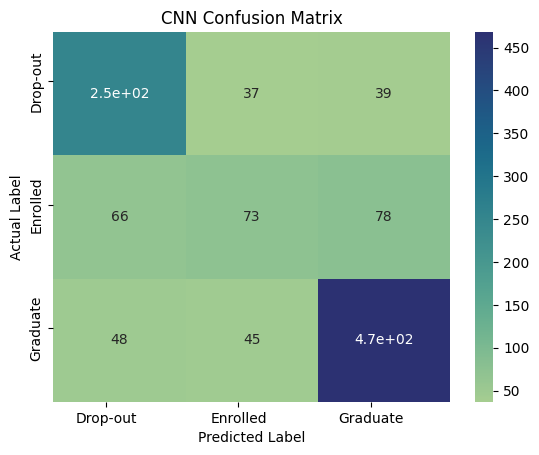

In [14]:
y_train_pred = nn.predict(X_test)
cnn_matrix = confusion_matrix(y_test,y_train_pred)
plot_confusion_matrix(cnn_matrix, title="CNN Confusion Matrix")

# Random Forest Classifier

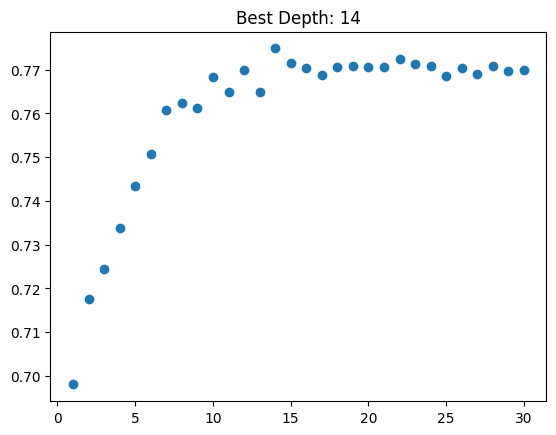

In [15]:
best_depth = find_best_depth(RandomForestClassifier)

In [16]:
RF = RandomForestClassifier(max_depth=best_depth,random_state=1111)
RF.fit(X_train,y_train)

y_train_pred = RF.predict(X_test)
RF_matrix = confusion_matrix(y_test,y_train_pred)

In [17]:
RF.score(X_test,y_test)

0.7757685352622061

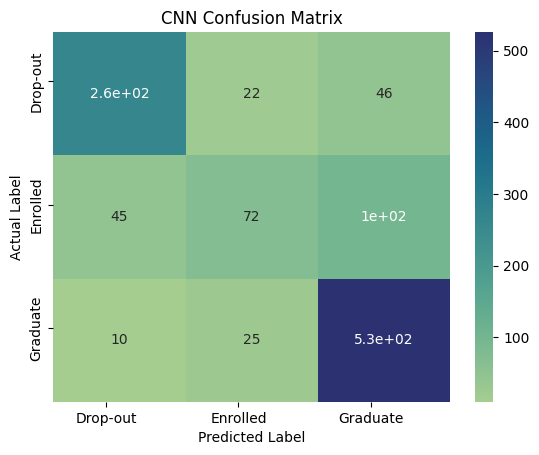

In [18]:
plot_confusion_matrix(RF_matrix,title="CNN Confusion Matrix")